<a href="https://colab.research.google.com/github/timothy2077/1st-Rep/blob/master/Exploration_Project__F_082624.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12-1. 프로젝트: ControlNet으로 조건을 준 이미지 생성하기

In [ ]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 26.4 MB/s eta 0:00:00


In [13]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. 윤곽선 검출

In [ ]:
!pip install diffusers

### 요하네스 베르메르(Johannes Vermeer)의 진주 귀걸이를 한 소녀(Girl with a Pearl Earring) 불러오기

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

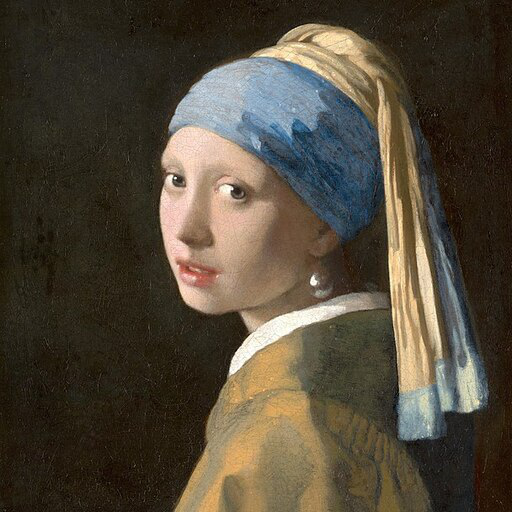

In [ ]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

### OpenCV를 사용하여 이미지의 윤곽선을 검출하기

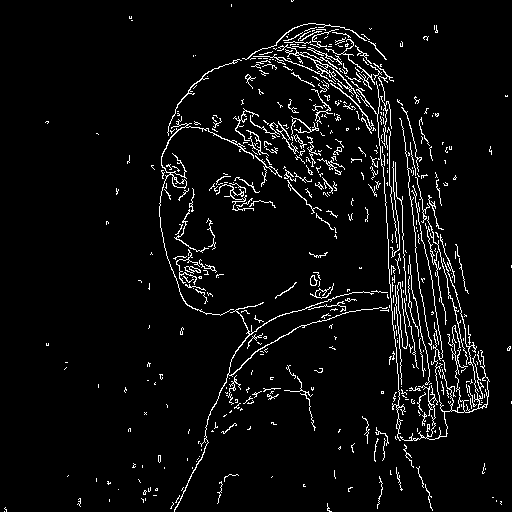

In [ ]:
import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image

### 윤곽선 검출 전처리기를 사용한 모델 파이프라인을 불러오기

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### TensorFlow가 GPU를 사용하여 연산가능 확인

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if not device_name:
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


### 윤곽선을 추출한 이미지에 프롬프트를 적용하여 새로운 이미지를 생성하기

In [ ]:
!pip install diffusers
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import cv2
import numpy as np
import torch
from PIL import Image

# Canny Edge Detection 전처리 함수
def apply_canny_edge_detection(image_url):
    image = load_image(image_url)
    gray_image = np.array(image.convert("L"))  # 이미지를 흑백으로 변환
    edges = cv2.Canny(gray_image, 100, 200)  # Canny Edge Detection 적용
    canny_image = Image.fromarray(edges).convert("RGB")  # NumPy 배열을 PIL 이미지로 변환
    return canny_image

# Canny에 대한 ControlNet 모델 로드
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny")

# Stable Diffusion 파이프라인에 ControlNet 추가
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=canny_controlnet
)

# 스케줄러 설정
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)

# CUDA 사용
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 불러오고 Canny Edge Detection 적용
image_url = "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
canny_image = apply_canny_edge_detection(image_url)

# 이미지를 생성합니다.
generated_image = canny_pipe(
    prompt="a serene landscape with a windmill and a river, in the style of Vermeer",
    num_inference_steps=20,
    generator=generator,
    image=canny_image  # Canny Edge Detection 결과 전달
).images[0]
# 생성된 이미지를 저장합니다.
generated_image.save("./canny_image.png")

# 생성된 이미지를 출력합니다.
generated_image.show()



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

### 프롬프트와 부정적인 프롬프트는 ChatGPT를 이용하여 생성하기

In [ ]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요.
from diffusers import UniPCMultistepScheduler
import torch

# 파이프라인 설정
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 프롬프트와 부정적인 프롬프트 설정
prompt = "disco dancer with colorful lights"
negative_prompt = "blurry, low quality"

# 이미지를 생성합니다.
canny_image = canny_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
canny_image.save("/aiffel/aiffel/canny_image.png")

# 생성된 이미지를 출력합니다.
canny_image.show()


## 2. 인체 자세 감지

###  사람의 전신이 담긴 이미지를 불러오기

In [ ]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

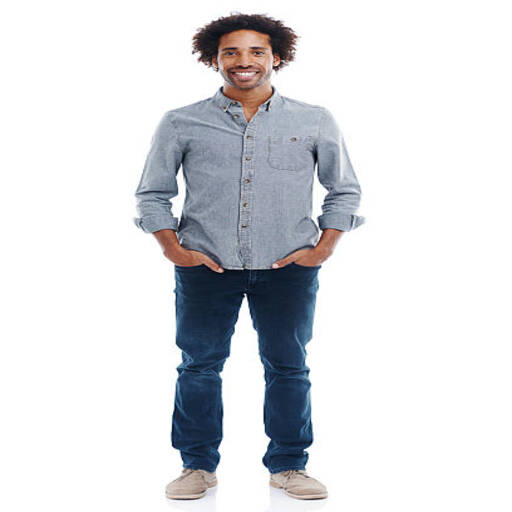

In [ ]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

### Openpose 검출기를 사용하여 자세만 추출하기

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

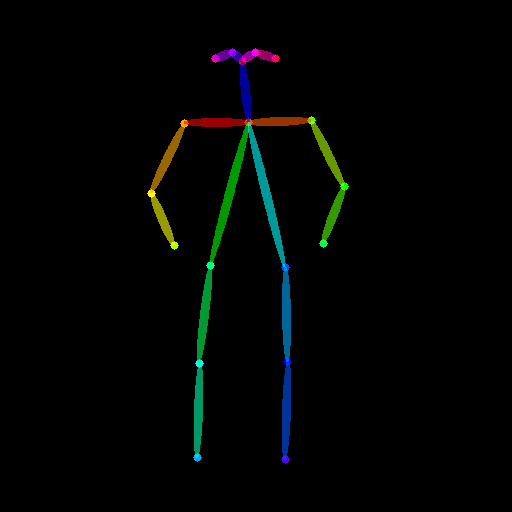

In [ ]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

### Openpose 전처리기를 사용한 모델 파이프라인을 불러오기

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Canny Edge Detection에서 사용한 코드를 참고 하이퍼파라미터를 조절하여 이미지 생성하기

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 프롬프트와 부정적인 프롬프트 설정
prompt = "A stylish young woman riding a bicycle in an urban setting. She is wearing a fashionable outfit"
negative_prompt = "blurry, low quality, dark"

# 이미지 URL
image_url = "https://images.unsplash.com/flagged/photo-1556151994-b611e5ab3675?w=400&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8OTF8fGJpa2luaSUyMG1vZGVsJTIwZnJlZSUyMHNhbXBsZXxlbnwwfHwwfHx8MA%3D%3D"

# 이미지 다운로드
response = requests.get(image_url)
# 바이트 스트림에서 이미지 열기
openpose_image = Image.open(BytesIO(response.content))

# 이미지를 생성합니다.
openpose_image = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,  # 추론 횟수 증가
    guidance_scale=7.5,  # 프롬프트에 근접한 이미지 생성
    controlnet_conditioning_scale=1.0,  # ControlNet 조건 설정
    generator=generator,
    image=openpose_image # Now 'openpose_image' is defined
).images[0]


# 생성된 이미지를 저장합니다.
openpose_image.save("/aiffel/aiffel/openpose_image.png")

# 생성된 이미지를 출력합니다.
openpose_image.show()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.0 MB/s eta 0:00:00


In [ ]:
!pip install diffusers
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch
from PIL import Image
import requests
from io import BytesIO

# Load the ControlNet model with mixed precision
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

# Move the pipeline to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
openpose_pipe = openpose_pipe.to(device)

# Set the seed for reproducibility
generator = torch.manual_seed(0)

# Define the prompt and negative prompt
prompt = "a futuristic cityscape with flying cars"
negative_prompt = "blurry, low quality, dark"

# Image URL
image_url = "https://images.unsplash.com/flagged/photo-1556151994-b611e5ab3675?w=400&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8OTF8fGJpa2luaSUyMG1vZGVsJTIwZnJlZSUyMHNhbXBsZXxlbnwwfHwwfHx8MA%3D%3D"

# Download the image
response = requests.get(image_url)
# Open the image from the byte stream
openpose_image = Image.open(BytesIO(response.content))

# Resize the image to reduce GPU usage
openpose_image = openpose_image.resize((256, 256))

# Generate the image with reduced inference steps
openpose_image = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,  # Reduced inference steps
    guidance_scale=7.5,  # Prompt adherence
    controlnet_conditioning_scale=1.0,  # ControlNet conditioning
    generator=generator,
    image=openpose_image
).images[0]

# Save the generated image
openpose_image.save("/aiffel/aiffel/openpose_image.png")

# Display the generated image
openpose_image.show()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

  0%|          | 0/20 [00:00<?, ?it/s]

### 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성하기

In [ ]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요.
from diffusers import UniPCMultistepScheduler
import torch

# 파이프라인 설정
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 프롬프트와 부정적인 프롬프트 설정
prompt = "a futuristic cityscape with flying cars"
negative_prompt = "blurry, low quality, dark"

# 이미지를 생성합니다.
openpose_image = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,  # 추론 횟수 증가
    guidance_scale=7.5,  # 프롬프트에 근접한 이미지 생성
    controlnet_conditioning_scale=1.0,  # ControlNet 조건 설정
    generator=generator,
    image=openpose_image
).images[0]

# 생성된 이미지를 저장합니다.
openpose_image.save("/aiffel/aiffel/openpose_image.png")

# 생성된 이미지를 출력합니다.
openpose_image.show()


## 3. 윤곽선 검출 + 인체 자세 감지


### Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달하기를 통한 새로운 이미지 생성하기


In [5]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 34.7 MB/s eta 0:00:00


In [8]:
!pip install torch
import torch

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

In [9]:
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

In [11]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

controlnets = [canny_controlnet, openpose_controlnet]

# Pass the list of controlnets to the pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# Move the pipeline to the GPU if available
if torch.cuda.is_available():
    pipe = pipe.to("cuda")
else:
    print("Warning: No GPU detected. Using CPU for processing.")

# Define the prompt
prompt = "A stylish young woman riding a bicycle in an urban setting. She is wearing a fashionable outfit"
negative_prompt = "dark, blurry, low quality, abstract, surreal, exaggerated, unrealistic, muted colors, chaotic background, low resolution, rough brushstrokes, cartoonish"

# Set the seed for reproducibility
generator = torch.manual_seed(0)

# Resize images to have the same dimensions
width, height = canny_image.size
openpose_image = openpose_image.resize((width, height))

images = [canny_image, openpose_image]

# Generate the image
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    generator=generator,
    image=images
).images[0]

# Save the generated image
image.save("multi_controlnet_output.png")

# Display the generated image
openpose_image.show()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# 12장 프로젝트 마지막 실행(Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달하기 최종결과물

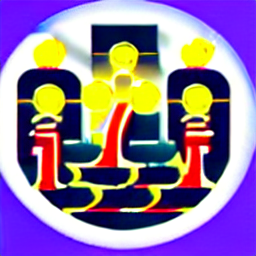